# Model Creation for Toxicity Classifier

## Downloading Datasets from Kaggle

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
print(os.getcwd())
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/Kaggle'

/content


In [ ]:
!kaggle datasets download -d ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
!kaggle datasets download -d oswinrh/indonesian-stoplist

!unzip 'indonesian-abusive-and-hate-speech-twitter-text.zip' -d 'abusive_text_dataset'
!unzip 'indonesian-stoplist.zip' -d 'stoplist_dataset'

  0% 0.00/814k [00:00<?, ?B/s]
100% 814k/814k [00:00<00:00, 110MB/s]
  0% 0.00/2.27k [00:00<?, ?B/s]
100% 2.27k/2.27k [00:00<00:00, 2.65MB/s]
Archive:  indonesian-abusive-and-hate-speech-twitter-text.zip
  inflating: abusive_text_dataset/README.md  
  inflating: abusive_text_dataset/abusive.csv  
  inflating: abusive_text_dataset/citation.bib  
  inflating: abusive_text_dataset/data.csv  
  inflating: abusive_text_dataset/new_kamusalay.csv  
Archive:  indonesian-stoplist.zip
  inflating: stoplist_dataset/stopwordbahasa.csv  


## Importing Datasets Using Pandas

note: abusive sentences is the training data

In [ ]:
import pandas as pd

stopwords_path = '/content/stoplist_dataset/stopwordbahasa.csv'
abusive_words_path = '/content/abusive_text_dataset/abusive.csv'
alay_words_path = '/content/abusive_text_dataset/new_kamusalay.csv'
abusive_sentences_path = '/content/abusive_text_dataset/data.csv'

df_stopwords = pd.read_csv(stopwords_path, header=None)
df_stopwords = df_stopwords.rename(columns={0: 'stopword'})
df_abusive = pd.read_csv(abusive_words_path, encoding='latin-1')
df_alay = pd.read_csv(alay_words_path, encoding='latin-1', header=None)
df_alay = df_alay.rename(columns={0: 'original', 
                                  1: 'replacement'})
df_alay_map = dict(zip(df_alay['original'], df_alay['replacement']))
df_abusive_sentences = pd.read_csv(abusive_sentences_path, encoding='latin-1') 

### Checking the structure of each DataFrame




In [ ]:
df_stopwords.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [ ]:
df_abusive.head()

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing


In [ ]:
df_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [ ]:
df_abusive_sentences.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


### Checking if HS column corresponds with the HS_X columns

In [69]:
condition = df_abusive_sentences['HS'] != (df_abusive_sentences[df_abusive_sentences.columns[3:]].any(axis=1))
df_abusive_sentences[condition]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong


Therefore HS column is correct, HS will be 1 if any of HS_X columns contains 1

## Data Preprocessing

In [58]:
!pip install PySastrawi

     |████████████████████████████████| 210 kB 5.3 MB/s 


In [70]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('\r',' ',text) # Remove every '\r'
    text = re.sub('(?i)rt',' ',text) # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]','',text) # Remove every username
    text = re.sub('(?i)user','',text) # Remove every username
    text = re.sub('(?i)url',' ',text) # Remove every url
    text = re.sub(r'\\x..',' ',text) # Remove every emoji
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Remove characters repeating more than twice

    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 

    return text

def normalize_alay(text):
    words = text.split(' ')
    normalized_words= []
    for word in words:
      if word in df_alay_map:
        normalized_words.append(df_alay_map[word])
      else:
        normalized_words.append(word)
      normalized_sentences = " ".join(normalized_words)
    return normalized_sentences

def remove_stopword(text):
    cleaned_words= []
    for word in text.split(' '):
      if word in df_stopwords['stopword'].values:
        cleaned_words.append('')
      else:
        cleaned_words.append(word)
      cleaned_sentences = ' '.join(cleaned_words)
    cleaned_sentences = re.sub('  +', ' ', cleaned_sentences) # Remove extra spaces
    cleaned_sentences = cleaned_sentences.strip()
    return cleaned_sentences

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = remove_unnecessary_char(text)
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_alay(text)
    text = remove_stopword(text)
    text = stemming(text)

    return text


In [71]:
df_abusive_sentences['Tweet'] = df_abusive_sentences['Tweet'].apply(preprocess)

## Text Vectorization

In [72]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [73]:
# Run if Tensorflow version < 2.0
# !pip install --upgrade tensorflow

In [74]:
from tensorflow.keras.layers import TextVectorization

In [83]:
x = df_abusive_sentences['Tweet']
y = df_abusive_sentences[['HS','Abusive']].values

In [84]:
max_features = 200000

In [85]:
vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=1800,
                               output_mode='int')

In [86]:
vectorizer.adapt(x.values)

In [87]:
vectorized_text = vectorizer(x.values)

In [88]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8) #adjust constants based on dataset

In [89]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Building the Model

In [92]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [93]:
model = tf.keras.models.Sequential()

model.add(Embedding(max_features+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [95]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                      

### Training the Model

In [97]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
576/576 [==============================] - 52s 91ms/step - loss: 0.3860 - val_loss: 0.2589
Epoch 2/10
576/576 [==============================] - 53s 92ms/step - loss: 0.2537 - val_loss: 0.1814
Epoch 3/10
576/576 [==============================] - 52s 90ms/step - loss: 0.1946 - val_loss: 0.1496
Epoch 4/10
576/576 [==============================] - 52s 90ms/step - loss: 0.1576 - val_loss: 0.1243
Epoch 5/10
576/576 [==============================] - 52s 91ms/step - loss: 0.1276 - val_loss: 0.0886
Epoch 6/10
576/576 [==============================] - 53s 91ms/step - loss: 0.1013 - val_loss: 0.0782
Epoch 7/10
576/576 [==============================] - 53s 91ms/step - loss: 0.0882 - val_loss: 0.0744
Epoch 8/10
576/576 [==============================] - 53s 91ms/step - loss: 0.0802 - val_loss: 0.0591
Epoch 9/10
576/576 [==============================] - 53s 91ms/step - loss: 0.0712 - val_loss: 0.0514
Epoch 10/10
576/576 [==============================] - 52s 91ms/step - loss: 0.061

In [98]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

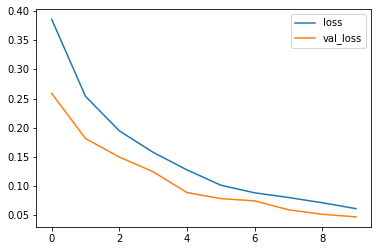

In [99]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Testing the Model with User Inputs

# Converting to TensorFlow Lite